In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

from ipynb.fs.full.SeedFinder import all_seeds

In [2]:
def display_seed(seed):
    plt.imshow(seed, cmap='gray')
    plt.title(f'seed')
    plt.colorbar()
    plt.show()

In [3]:
def find_seed_contour(seed, threshold=400):
    normalized_image = cv2.normalize(seed.copy(), None, 0, 255, cv2.NORM_MINMAX)
    image_uint8 = normalized_image.astype(np.uint8)

    _, binary_image = cv2.threshold(image_uint8, int(threshold * 255 / 4096), 255, cv2.THRESH_BINARY)

    contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return max(contours, key=cv2.contourArea)

In [4]:
def extract_width_height_from_contour(contour):
    rightmost_point = max(contour, key=lambda point: point[0][0])  # Max x-coordinate
    leftmost_point = min(contour, key=lambda point: point[0][0])  # Min x-coordinate
    uppermost_point = min(contour, key=lambda point: point[0][1])  # Min y-coordinate
    downmost_point = max(contour, key=lambda point: point[0][1])  # Max y-coordinate
    y_uppermost, x_leftmost = uppermost_point[0][1] - 1, leftmost_point[0][0] - 1
    y_downmost, x_rightmost = downmost_point[0][1] + 1, rightmost_point[0][0] + 1
    return x_rightmost - x_leftmost + 1, y_downmost - y_uppermost + 1, x_leftmost, y_uppermost

In [5]:
def find_seed_width_height_area(seed):
    seed_contour = find_seed_contour(seed)
    area = cv2.contourArea(seed_contour)
    return *extract_width_height_from_contour(seed_contour), area

In [6]:
from scipy.spatial import Delaunay

def find_seed_mask(seed):
    contour = find_seed_contour(seed)
    width, height, x_start, y_start, _ = find_seed_width_height_area(seed)
    points = contour.reshape(-1, 2)
    tri = Delaunay(points)
    mask = np.zeros(seed.shape, dtype=np.uint8)
    for simplex in tri.simplices:
        triangle = points[simplex]
        cv2.fillConvexPoly(mask, triangle, 255)
    cv2.drawContours(mask, contour, -1, (255), thickness=cv2.FILLED)
    mask = mask[y_start:y_start+height, x_start:x_start+width]
    return mask, y_start, x_start, height, width

In [7]:
def find_seed_masked_image(seed):
    mask, y_start, x_start, height, width = find_seed_mask(seed)
    masked_image = cv2.bitwise_and(seed[y_start:y_start+height, x_start:x_start+width], seed[y_start:y_start+height, x_start:x_start+width], mask=mask)
    return masked_image

In [8]:
def extract_seed_pixels(seed, start_band=100, end_band=740):
    _, y_start, x_start, height, width = find_seed_mask(seed[:,:,200])
    seed_mask_all_bands = seed[y_start:y_start+height,x_start:x_start+width,start_band:end_band]
    # TODO add choice to find all the nonzero spatial pixels in the middle band or all bands because the middle band has more pixels and all bands has less noise
    seed_pixels_200 = np.argwhere(seed_mask_all_bands[:,:,200])
    return seed_mask_all_bands[seed_pixels_200[:, 0], seed_pixels_200[:, 1], :], seed_pixels_200, seed_mask_all_bands.shape
    # return seed_mask_all_bands[seed_pixels_200[:, 0], seed_pixels_200[:, 1], :], seed_pixels_200, seed_mask_all_bands, y_start, x_start

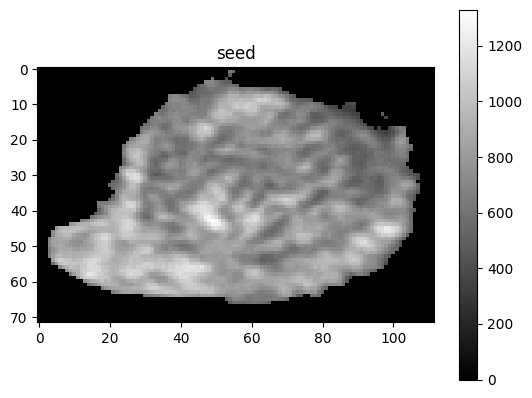

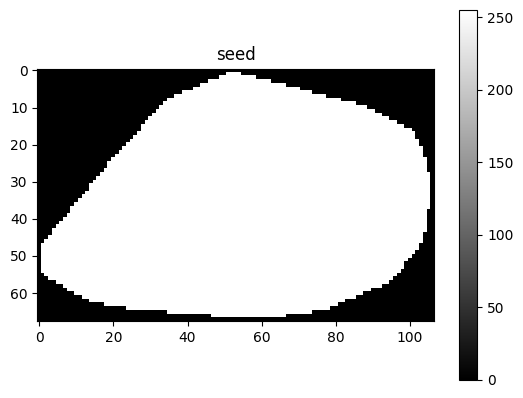

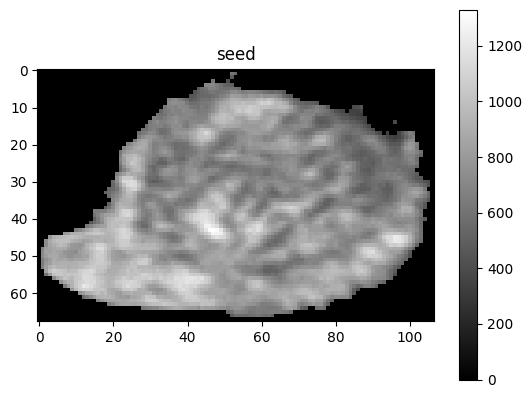

In [9]:
seed = np.load(all_seeds[0])[:,:,200]
mask, y_start, x_start, height, width = find_seed_mask(seed)
masked_image = find_seed_masked_image(seed)

display_seed(seed)
display_seed(mask)
display_seed(masked_image)

In [10]:
seed = np.load(all_seeds[0])
seed_pixels, seed_pixels_spatial_indices, shape = extract_seed_pixels(seed)